# BERT (Pre-training of Deep Bidirectional Transformers for Language Understanding)

BERT is a method of pre-training language representations, meaning that we train a general-purpose "language understanding" model on a large text corpus (like Wikipedia), and then use that model for downstream NLP tasks that we care about (like question answering). BERT outperforms previous methods because it is the first unsupervised, deeply bidirectional system for pre-training NLP.

Unsupervised means that BERT was trained using only a plain text corpus, which is important because an enormous amount of plain text data is publicly available on the web in many languages.

Pre-trained representations can also either be context-free or contextual, and contextual representations can further be unidirectional or bidirectional. [Context-free models such as word2vec or GloVe](`codex/py/keras/6. AutoEncoders and Embeddings/6.8 Word Embeddings.ipynb`) generate a single "word embedding" representation for each word in the vocabulary, so bank would have the same representation in bank deposit and river bank. Contextual models instead generate a representation of each word that is based on the other words in the sentence.

BERT was built upon recent work in pre-training contextual representations. BERT represents "bank" using both its left and right context — I made a ... deposit — starting from the very bottom of a deep neural network, so it is deeply bidirectional.

# Case Study: QA using SQuAD (Stanford Question-Answering Dataset)

https://keras.io/examples/nlp/text_extraction_with_bert/

Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

> pip install tokenizers transformers

In [1]:
import os

# os.environ['USE_TF'] = 'None' # `ValueError: tensorflow.__spec__ is None`. But this makes tf unavailable

import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

max_len = 384
configuration = BertConfig()  # default parameters and configuration for BERT

## Trouble shooting: No module named 'keras.saving.hdf5_format'

### Solution: 

Revise: ~\anaconda3\lib\site-packages\transformers\modeling_tf_utils.py

```

from huggingface_hub import Repository, list_repo_files
# from keras.saving.hdf5_format import save_attributes_to_hdf5_group
from transformers.utils.hub import convert_file_size_to_int, get_checkpoint_shard_files

```

In [2]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

## Prepare the SQuAD dataset

Only run this section once.

In [3]:
train_path = "SQuAD_train-v1.1.json"
eval_path = "SQuAD_dev-v1.1.json"

In [4]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text, all_answers):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets


with open(train_path) as f:
    raw_train_data = json.load(f)

with open(eval_path) as f:
    raw_eval_data = json.load(f)


def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                all_answers = [_["text"] for _ in qa["answers"]]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text, all_answers
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y


train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")


87599 training points created.
10570 evaluation points created.


In [7]:
import pickle
with open('squad_dataset.pickle', 'wb') as f:
    pickle.dump((x_train, y_train, x_eval, y_eval, raw_eval_data), f)

## End of preparation of dataset

<hr/>

## Reload dataset directly from pkl

In [12]:
import pickle
with open('squad_dataset.pickle', 'rb') as f:
    x_train, y_train, x_eval, y_eval, raw_eval_data = pickle.load(f)

In [ ]:
def create_squad_examples(raw_data):
    squad_examples = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                answer_text = qa["answers"][0]["text"]
                all_answers = [_["text"] for _ in qa["answers"]]
                start_char_idx = qa["answers"][0]["answer_start"]
                squad_eg = SquadExample(
                    question, context, start_char_idx, answer_text, all_answers
                )
                squad_eg.preprocess()
                squad_examples.append(squad_eg)
    return squad_examples

eval_squad_examples = create_squad_examples(raw_eval_data)

In [3]:
def create_model():
    
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## QA Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]

    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
    end_logits = layers.Flatten()(end_logits)

    start_probs = layers.Activation(keras.activations.softmax)(start_logits)
    end_probs = layers.Activation(keras.activations.softmax)(end_logits)

    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[start_probs, end_probs],
    )
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss=[loss, loss])
    
    return model

In [4]:
use_tpu = False
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_3[0][0]',            

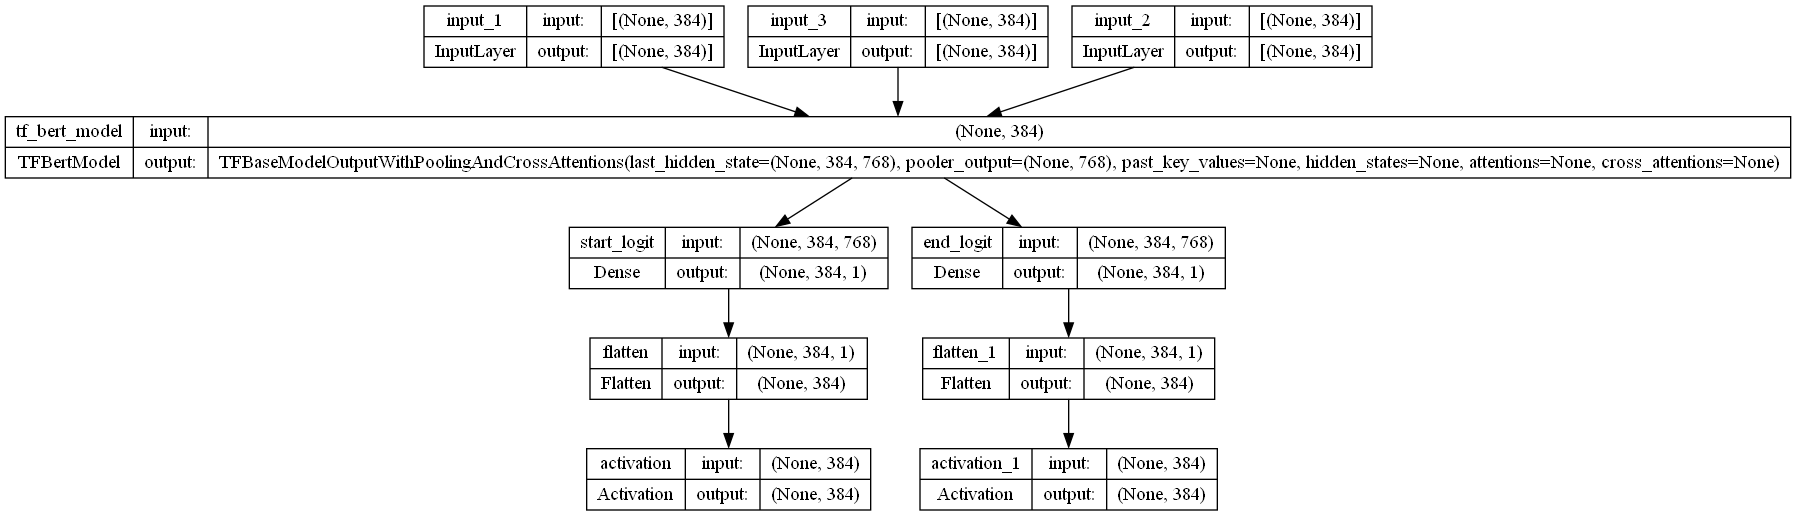

In [7]:
from keras.utils import plot_model
plot_model(model, to_file='bert.png', show_shapes=True)

In [8]:
def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text


class ExactMatch(keras.callbacks.Callback):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)
            normalized_true_ans = [normalize_text(_) for _ in squad_eg.all_answers]
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")


In [ ]:
exact_match_callback = ExactMatch(x_eval, y_eval)
model.fit(
    x_train,
    y_train,
    epochs=3,  # For demonstration, 3 epochs are recommended
    verbose=2,
    batch_size=8,
    callbacks=[exact_match_callback],
)

Epoch 1/3


In [ ]:
model.save('bert.hdf5')

In [ ]:
from keras.models import load_model
model = load_model('bert.hdf5')

<hr/>


# Directly use the fine-tuned BERT model from huggingface.

The model is downloaded to './bert-finetuned-squad'.

https://huggingface.co/csarron/bert-base-uncased-squad-v1

In [4]:
import torch
from transformers import AutoModel, BertTokenizer
from pytorch_pretrained_bert import BertForQuestionAnswering

# model = AutoModel.from_pretrained("bert-finetuned-squad/")
model = BertForQuestionAnswering.from_pretrained('bert-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-finetuned-squad')

In [12]:
model

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
        

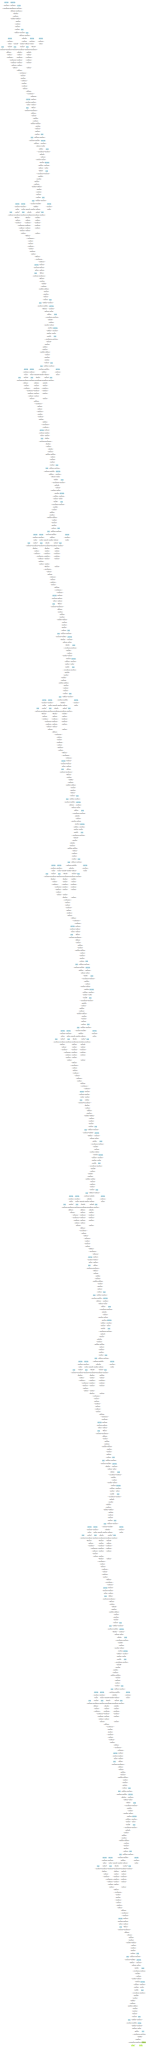

In [13]:
from torchviz import make_dot
import torch

x = torch.zeros(1, 512, dtype=torch.int, requires_grad=False)
out = model(x)
make_dot(out)  # plot graph of variable, not of a nn.Module

## Make some tests

In [9]:
from transformers import pipeline

qa_pipeline = pipeline(
    "question-answering",
    model='bert-finetuned-squad',
    tokenizer='bert-finetuned-squad'
)

qa_pipeline({
    'context': "Manuel Romero has been working hardly in the repository hugginface/transformers lately",
    'question': "Who has been working hard for hugginface/transformers lately?"

})

{'score': 0.9997913837432861, 'start': 0, 'end': 13, 'answer': 'Manuel Romero'}

In [14]:
qa_pipeline({
    'context': "Manuel Romero has been working hardly in the repository hugginface/transformers lately",
    'question': "For which company has worked Manuel Romero?"
})

{'score': 0.8251159191131592,
 'start': 56,
 'end': 79,
 'answer': 'hugginface/transformers'}

In [17]:
qa_pipeline({
    'context': """New York (CNN) -- More than 80 Michael Jackson collectibles -- including the late pop star's famous rhinestone-studded glove from a 1983 performance -- were auctioned off Saturday, reaping a total $2 million. Profits from the auction at the Hard Rock Cafe in New York's Times Square crushed pre-sale expectations of only $120,000 in sales. The highly prized memorabilia, which included items spanning the many stages of Jackson's career, came from more than 30 fans, associates and family members, who contacted Julien's Auctions to sell their gifts and mementos of the singer. Jackson's flashy glove was the big-ticket item of the night, fetching $420,000 from a buyer in Hong Kong, China. Jackson wore the glove at a 1983 performance during \"Motown 25,\" an NBC special where he debuted his revolutionary moonwalk. Fellow Motown star Walter \"Clyde\" Orange of the Commodores, who also performed in the special 26 years ago, said he asked for Jackson's autograph at the time, but Jackson gave him the glove instead. "The legacy that [Jackson] left behind is bigger than life for me,\" Orange said. \"I hope that through that glove people can see what he was trying to say in his music and what he said in his music.\" Orange said he plans to give a portion of the proceeds to charity. Hoffman Ma, who bought the glove on behalf of Ponte 16 Resort in Macau, paid a 25 percent buyer's premium, which was tacked onto all final sales over $50,000. Winners of items less than $50,000 paid a 20 percent premium.""",
    'question': "Where was the Auction held?"
})

{'score': 0.0001800096215447411,
 'start': 241,
 'end': 282,
 'answer': "Hard Rock Cafe in New York's Times Square"}

In [18]:
qa_pipeline({
    'context': """The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula.   The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail.   In March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online.   The Vatican Secret Archives were separated from the library at the beginning of the 17th century; they contain another 150,000 items.   Scholars have traditionally divided the history of the library into five periods, Pre-Lateran, Lateran, Avignon, Pre-Vatican and Vatican.   The Pre-Lateran period, comprising the initial days of the library, dated from the earliest days of the Church. Only a handful of volumes survive from this period, though some are very significant.""",
    'question': "When was the Vat formally opened?"
})

{'score': 0.9472551345825195, 'start': 175, 'end': 179, 'answer': '1475'}